In [1]:
import numpy as np
import scipy as sp
# impor binomial distribution
from scipy.stats import binom
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def smooth(y):
    # smooth with a moving average
    window_size = 25
    y_smooth = np.zeros(y.shape[0])
    for i in range(y.shape[0] - window_size):
        y_smooth[i] = np.mean(y[max(i - window_size, 0):i])
    return y_smooth

# Sample from the LP curve
def probs_from_lp(y):
    posidxs = [i for (i, lp) in enumerate(y) if lp > 0]
    zeroout = len(posidxs) > 0
    subprobs = y[posidxs] if  zeroout else y
    std = np.std(subprobs)
    subprobs = (subprobs - np.mean(subprobs)) / (std if std else 1)
    subprobs = sigmoid(subprobs)
    subprobs = subprobs / np.sum(subprobs)
    if zeroout:
        task_probs = np.zeros(y.shape[0])
        task_probs[posidxs] = subprobs
    else:
        task_probs = subprobs
    return task_probs

(16000,)


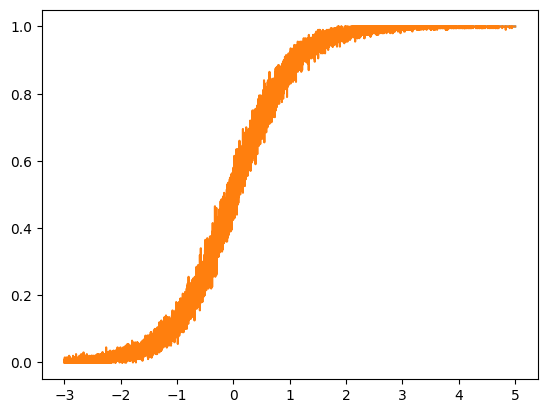

In [3]:
x = np.arange(-3, 5, 0.0005)
print(x.shape)
tan_x = (np.tanh(x) + 1) / 2
plt.plot(x, tan_x)
y = np.copy(tan_x)

# Given the y values, we want to use that as a win-rate for a binomial distribution
# at each x value, we want to sample 200 times from the binomial distribution
# and then plot a jagged line curve of the win-rate
n = 200
for i in range(len(x)):
    p = y[i]
    y[i] = binom.rvs(n, p) / n

plt.plot(x, y)

# plot the slope of the tanh function
# slope = np.gradient(np.tanh(x), x)
# plt.plot(x, slope)

In [ ]:
class BiDirectionalLP:
    def __init__(self, max_num_levels = 8192, ema_alpha = 0.001, p_theta = 0.05):
        """
        parser.add_argument("--ema-alpha", type=float, default=0.1,
                            help="smoothing value for ema in claculating learning progress (default: 0.1)")
        parser.add_argument("--p-theta", type=float, default=0.1,
                            help="parameter for reweighing learning progress (default: 0.1)")
        """
        self.n = max_num_levels
        self.ema_alpha = ema_alpha
        self.p_theta = p_theta
        self.ema_tsr = None
        self.p_fast = None
        self.p_slow = None

    # undo vectorization over 
    def learning_progress(self, y):
        # calculate the learning progress
        # normalize task success rates with random baseline rates
        ema_alpha = self.ema_alpha
        p_theta = self.p_theta
        ema_tsr = np.zeros(y.shape[0])
        p_fast = np.zeros(y.shape[0])
        p_slow = np.zeros(y.shape[0])

        for i in range(len(x)):
            random_success_rate = np.random.rand()
            norm_y = np.maximum(y[i] - random_success_rate, 0) / (1.0 - random_success_rate)
            ema_tsr[i] = y[i]           * ema_alpha + ema_tsr[i-1] * (1 - ema_alpha) if ema_tsr[i-1] != 0 else y[i]
            p_fast[i]  = norm_y         * ema_alpha + p_fast[i-1]  * (1 - ema_alpha) if p_fast[i-1] != 0 else norm_y
            p_slow[i]  = p_fast[i]      * ema_alpha + p_slow[i-1]  * (1 - ema_alpha) if p_slow[i-1] != 0 else p_fast[i]

        p_fast_reweigh = ((1 - p_theta) * p_fast) / (p_fast + p_theta * (1 - 2 * p_fast))
        p_slow_reweigh = ((1 - p_theta) * p_slow) / (p_slow + p_theta * (1 - 2 * p_slow))
        learning_progress = np.abs(p_fast_reweigh - p_slow_reweigh)
        unweighted_learning_progress = np.abs(p_fast - p_slow)
        return learning_progress, unweighted_learning_progress, p_fast, p_slow, p_fast_reweigh, p_slow_reweigh

/root/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/.local/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


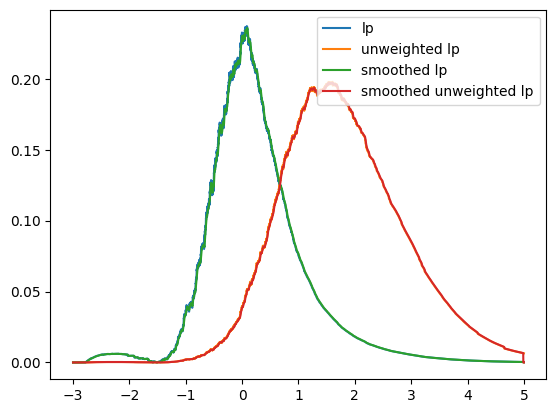

In [5]:
LP = BiDirectionalLP()

ema_alpha = 0.001
p_theta = 0.05
ema_tsr = np.zeros(y.shape[0])
p_fast = np.zeros(y.shape[0])
p_slow = np.zeros(y.shape[0])

for i in range(len(x)):
    random_success_rate = np.random.rand()
    norm_y = np.maximum(y[i] - random_success_rate, 0) / (1.0 - random_success_rate)
    ema_tsr[i] = y[i]           * ema_alpha + ema_tsr[i-1] * (1 - ema_alpha) if ema_tsr[i-1] != 0 else y[i]
    p_fast[i]  = norm_y      * ema_alpha + p_fast[i-1]  * (1 - ema_alpha) if p_fast[i-1] != 0 else norm_y
    p_slow[i]  = p_fast[i] * ema_alpha + p_slow[i-1]  * (1 - ema_alpha) if p_slow[i-1] != 0 else p_fast[i]

p_fast_reweigh = ((1 - p_theta) * p_fast) / (p_fast + p_theta * (1 - 2 * p_fast))
p_slow_reweigh = ((1 - p_theta) * p_slow) / (p_slow + p_theta * (1 - 2 * p_slow))
learning_progress = np.abs(p_fast_reweigh - p_slow_reweigh)
unweighted_learning_progress = np.abs(p_fast - p_slow)


# for _ in range(15):
# lp, unw_lp, p_fast, p_slow, p_fast_rw, p_slow_rw = LP.learning_progress(y)
plt.plot(x, learning_progress, label='lp')
plt.plot(x, unweighted_learning_progress, label='unweighted lp')
yy = smooth(learning_progress)
plt.plot(x, yy, label='smoothed lp')
plt.plot(x, smooth(unweighted_learning_progress), label='smoothed unweighted lp')
plt.legend()

In [6]:
probs = probs_from_lp(yy)
tasks = np.random.choice(x, 10, p=probs)
print(tasks, yy.shape, probs.sum())

[-1.606   2.992   2.199   2.9615 -0.403  -0.3185  4.7765  2.7465  1.374
  0.261 ] (16000,) 0.9999999999999999


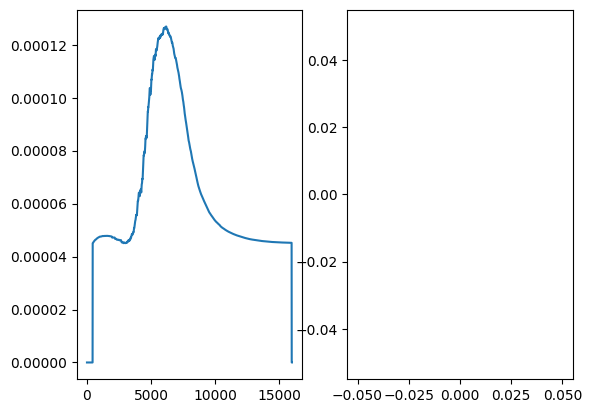

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(probs)
ax2.plot(np.cumsum(yy / np.sum(yy)))

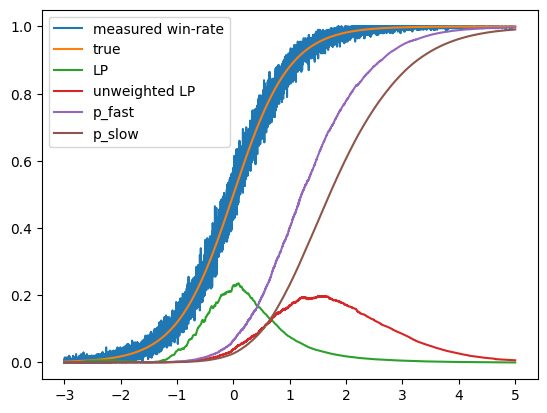

In [8]:
plt.plot(x, y, label='measured win-rate')
plt.plot(x, tan_x, label='true')
plt.plot(x, yy, label='LP')
plt.plot(x, unweighted_learning_progress, label='unweighted LP')
plt.plot(x, p_fast, label='p_fast')
plt.plot(x, p_slow, label='p_slow')
# plt.plot(x, p_fast_reweigh, label='p_fast_rw')
# plt.plot(x, p_slow_reweigh, label='p_slow_rw')
plt.legend()